![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Construcción y calibración de árboles de decisión

En este notebook aprenderá a construir árboles de decisión de dos maneras: uno, desarrollando el código manualmente; y dos, usando la librería especializada sklearn. Así mismo aprenderá a calibrarlos y a obtener la importancia de las variables para la predicción. 

## Instrucciones Generales:

El árbol de decisión que construirá por medio de este notebook deberá predecir si el salario de un beisbolista es alto (>425) dadas las variables de desempeño en su carrera. Por esta razón, los datos a usar en el notebook son los de las Grandes Ligas de Béisbol de las temporadas 1986 y 1987, para más detalles: https://rdrr.io/cran/ISLR/man/Hitters.html. 

Para realizar la actividad, solo siga las indicaciones asociadas a cada celda del notebook. 

## Importar base de datos y librerías

## HOLI

In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
import pandas as pd
import numpy as np

# Carga de datos de archivos .csv
url = 'https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/hitters.csv'
hitters = pd.read_csv(url)

# Eliminación filas con observaciones nulas
hitters.dropna(inplace=True)
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


## Codificar variables categóricas

In [3]:
hitters['League'] = pd.factorize(hitters.League)[0]
hitters['Division'] = pd.factorize(hitters.Division)[0]
hitters['NewLeague'] = pd.factorize(hitters.NewLeague)[0]
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,0,0,632,43,10,475.0,0
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,1,0,880,82,14,480.0,1
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,0,1,200,11,3,500.0,0
4,321,87,10,39,42,30,2,396,101,12,48,46,33,0,1,805,40,4,91.5,0
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,1,0,282,421,25,750.0,1


## Visualizar la información

<Axes: xlabel='Years', ylabel='Hits'>

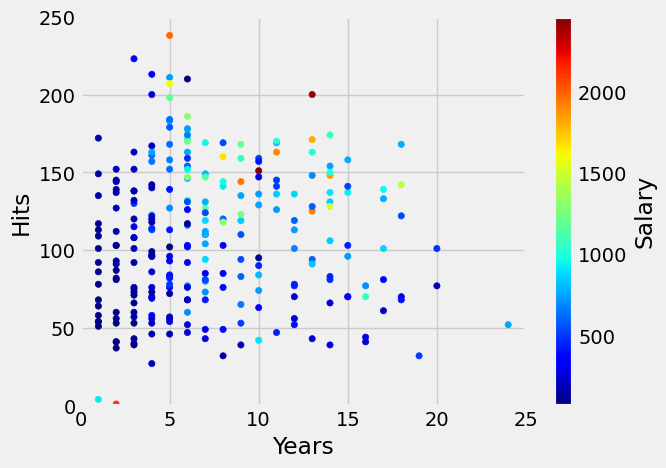

In [4]:
# Gráfica del salario, años y hits
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
hitters.plot(kind='scatter', x='Years', y='Hits', c='Salary', colormap='jet', xlim=(0, 25), ylim=(0, 250))

## Definir las varibles del problema - Predictores y varible de respuesta

In [5]:
# Selección de variables predictoras
feature_cols = hitters.columns[hitters.columns.str.startswith('C') == False].drop('Salary')
feature_cols

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'League',
       'Division', 'PutOuts', 'Assists', 'Errors', 'NewLeague'],
      dtype='object')

In [6]:
# Descripción de la variable de respuesta 'Salary'
hitters.Salary.describe()

count     263.000000
mean      535.925882
std       451.118681
min        67.500000
25%       190.000000
50%       425.000000
75%       750.000000
max      2460.000000
Name: Salary, dtype: float64

In [7]:
# Separación de variables predictoras (X) y variable de interes (y)
X = hitters[feature_cols]
y = (hitters.Salary > 425).astype(int)

In [8]:
X.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'League',
       'Division', 'PutOuts', 'Assists', 'Errors', 'NewLeague'],
      dtype='object')

## Construir un árbol de decisión manualmente

In [9]:
# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

### Ejemplo: para la primera variable ('Hits') se calculan los posibles puntos de corte y el gini index de un punto especifico

In [10]:
# Impresión variable a usar (Hits)
j = 1
print(X.columns[j])

Hits


In [11]:
# División de la variable Hits en num_ctp puntos (parámetro definido anteriormente) para obtener posibles puntos de corte
splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())
splits = np.unique(splits)
splits

array([  1. ,  52. ,  66.8,  77. ,  92. , 103. , 120. , 136. , 148.6,
       168. ])

In [12]:
# División de las observaciones usando el punto de corte en la posición 5 de la lista de splits
k=5
filter_l = X.iloc[:, j] < splits[k]

# División de la variable de respuesta de acuerdo a si la observación cumple o no con la regla binaria
# y_l: la observación tiene un valor menor al punto de corte seleccionado
# y_r: la observación tiene un valor mayor o igual al punto de corte seleccionado
y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [13]:
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [14]:
# Gini index de las observaciones que tienen un valor menor al punto de corte seleccionado
gini_l = gini(y_l)
gini_l

0.39928079856159704

In [15]:
# Gini index de las observaciones que tienen un valor mayor o igual al punto de corte seleccionado
gini_r = gini(y_r)
gini_r

0.42690311418685123

In [16]:
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [17]:
# Ganancia de la variable 'Hits' en el punto de corte selecionado
gini_impurity(X.iloc[:, j], y, splits[k])

0.0862547016583845

### Para todas las variables se calculan sus posibles puntos de corte y se selecciona aquella que de la menor impureza o ganancia 

In [18]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [19]:
# Obtención de la variable 'j', su punto de corte 'split' y su ganancia 'gain'
j, split, gain = best_split(X, y, 5)
j, split, gain

(6, 6.0, 0.1428365268140297)

In [20]:
# División de las observaciones usando la mejor variable 'j' y su punto de corte 'split'
filter_l = X.iloc[:, j] < split

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [21]:
y.shape[0], y_l.shape[0], y_r.shape[0]

(263, 116, 147)

In [22]:
y.mean(), y_l.mean(), y_r.mean()

(0.49049429657794674, 0.1896551724137931, 0.7278911564625851)

### Crecimiento recursivo del árbol 

In [23]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [24]:
# Aplicación de la función tree_grow
tree_grow(X, y, level=0, min_gain=0.001, max_depth=1, num_pct=10)

{'y_pred': 0,
 'y_prob': 0.49056603773584906,
 'level': 0,
 'split': [6, 5.0],
 'n_samples': 263,
 'gain': 0.15865574114903452,
 'sl': {'y_pred': 0,
  'y_prob': 0.10869565217391304,
  'level': 1,
  'split': -1,
  'n_samples': 90,
  'gain': 0.01935558112773289},
 'sr': {'y_pred': 1,
  'y_prob': 0.6914285714285714,
  'level': 1,
  'split': -1,
  'n_samples': 173,
  'gain': 0.1127122881295256}}

In [25]:
tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10)
tree

{'y_pred': 0,
 'y_prob': 0.49056603773584906,
 'level': 0,
 'split': [6, 5.0],
 'n_samples': 263,
 'gain': 0.15865574114903452,
 'sl': {'y_pred': 0,
  'y_prob': 0.10869565217391304,
  'level': 1,
  'split': [5, 65.0],
  'n_samples': 90,
  'gain': 0.01935558112773289,
  'sl': {'y_pred': 0,
   'y_prob': 0.07407407407407407,
   'level': 2,
   'split': [0, 185.0],
   'n_samples': 79,
   'gain': 0.009619566461418955,
   'sl': {'y_pred': 0,
    'y_prob': 0.3333333333333333,
    'level': 3,
    'split': -1,
    'n_samples': 7,
    'gain': 0.40816326530612246},
   'sr': {'y_pred': 0,
    'y_prob': 0.05405405405405406,
    'level': 3,
    'split': -1,
    'n_samples': 72,
    'gain': 0.009027777777777565}},
  'sr': {'y_pred': 0,
   'y_prob': 0.38461538461538464,
   'level': 2,
   'split': [0, 470.90909090909093],
   'n_samples': 11,
   'gain': 0.2203856749311295,
   'sl': {'y_pred': 0,
    'y_prob': 0.14285714285714285,
    'level': 3,
    'split': -1,
    'n_samples': 5,
    'gain': 0},
   'sr

### Realizar predicciones usando el árbol creado

In [26]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted


In [27]:
# Ejecución de función tree_predict
tree_predict(X, tree)

array([1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0.,
       1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 1.

## Construir un árbol de decisiones usando *Sklearn*

In [28]:
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

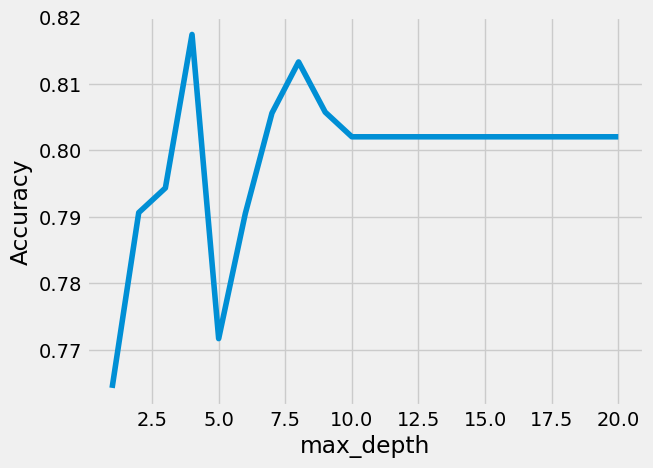

In [29]:
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [30]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.8173789173789172, 4)

In [31]:
# max_depth=4 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeClassifier(max_depth=4, random_state=1)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=4, random_state=1)

## Importancia de las variables 

In [32]:
# Uso de la función .feature_importances_ para obtener la importancia de cada variable
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

,feature,importance
0,AtBat,0.000000
7,League,0.000000
8,Division,0.000000
10,Assists,0.000000
11,Errors,0.000000
12,NewLeague,0.000000
9,PutOuts,0.006048
2,HmRun,0.010841
4,RBI,0.012073
3,Runs,0.021020


In [33]:
# Impresión de resultados de desemepeño del árbol de decisión
pd.Series(cross_val_score(clf, X, y, cv=10)).describe()

count    10.000000
mean      0.817379
std       0.084802
min       0.692308
25%       0.751781
50%       0.833333
75%       0.884615
max       0.923077
dtype: float64